# Setup

In [9]:

import tensorflow as tf
import ctypes
import gmpy2
from gmpy2 import mpz
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation, Dense
from keras.layers import Flatten, Reshape
from keras.layers import Conv1D
from keras.layers import concatenate
from keras.optimizers import Adam, RMSprop
from keras.models import load_model

In [5]:
def random_batch(X_train, y_train, batch_size):
    index_set = np.random.randint(0, X_train.shape[0], batch_size)
    X_batch = X_train[index_set]
    y_batch = y_train[index_set]
    return X_batch, y_batch

#Model Structure

In [6]:
model_name = 'ANC'

#the standard parameters: message, key, and ciphertext bit lengths
m_bits = 8
k_bits = 8
c_bits = 8
pad = 'same'

# Compute the size of the message space
m_train = 2**(m_bits + k_bits)

alice_file = 'models/crypto/' + model_name + '-alice'
bob_file = 'models/crypto/' + model_name + '-bob'
eve_file = 'models/crypto/' + model_name + '-eve'

### Network arch

In [7]:
K.clear_session()
kersize = 4

##### Alice network #####
#
alice_input0 = Input(shape=(m_bits,)) #message
alice_input1 = Input(shape=(k_bits,)) #key
alice_input = concatenate([alice_input0, alice_input1], axis=1)

alice_dense1 = Dense(units=(m_bits + k_bits))(alice_input)
alice_dense1a = Activation('tanh')(alice_dense1)

alice_reshape = Reshape((m_bits + k_bits, 1,))(alice_dense1a)

alice_conv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(alice_reshape)
alice_conv1a = Activation('tanh')(alice_conv1)
alice_conv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(alice_conv1a)
alice_conv2a = Activation('tanh')(alice_conv2)
alice_conv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(alice_conv2a)
alice_conv3a = Activation('tanh')(alice_conv3)
alice_conv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(alice_conv3a)
alice_conv4a = Activation('tanh')(alice_conv4)

alice_flat = Flatten()(alice_conv4a)
alice_output = Dense(units=c_bits, activation='tanh')(alice_flat) #ciphertext

alice = Model([alice_input0, alice_input1], alice_output, name='alice')
alice.summary()


##### Bob network #####
#
bob_input0 = Input(shape=(c_bits,)) #ciphertext
bob_input1 = Input(shape=(k_bits,)) #key
bob_input = concatenate([bob_input0, bob_input1], axis=1)

bob_dense1 = Dense(units=(c_bits + k_bits))(bob_input)
bob_dense1a = Activation('tanh')(bob_dense1)

bob_reshape = Reshape((c_bits + k_bits, 1,))(bob_dense1a)

bob_conv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bob_reshape)
bob_conv1a = Activation('tanh')(bob_conv1)
bob_conv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bob_conv1a)
bob_conv2a = Activation('tanh')(bob_conv2)
bob_conv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bob_conv2a)
bob_conv3a = Activation('tanh')(bob_conv3)
bob_conv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bob_conv3a)
bob_conv4a = Activation('tanh')(bob_conv4)

bob_flat = Flatten()(bob_conv4a)
bob_output = Dense(units=m_bits, activation='sigmoid')(bob_flat) #decrypted message

bob = Model([bob_input0, bob_input1], bob_output, name='bob')
bob.summary()


# Eve network
eve_input = Input(shape=(c_bits,)) #ciphertext only

eve_dense1 = Dense(units=(c_bits + k_bits))(eve_input)
eve_dense1a = Activation('tanh')(eve_dense1)
eve_dense2 = Dense(units=(m_bits + k_bits))(eve_dense1a)
eve_dense2a = Activation('tanh')(eve_dense2)

eve_reshape = Reshape((m_bits + k_bits, 1,))(eve_dense2a)

eve_conv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(eve_reshape)
eve_conv1a = Activation('tanh')(eve_conv1)
eve_conv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(eve_conv1a)
eve_conv2a = Activation('tanh')(eve_conv2)
eve_conv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(eve_conv2a)
eve_conv3a = Activation('tanh')(eve_conv3)
eve_conv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(eve_conv3a)
eve_conv4a = Activation('tanh')(eve_conv4)

eve_flat = Flatten()(eve_conv4a)
eve_output = Dense(units=m_bits, activation='sigmoid')(eve_flat) #code break attempt

eve = Model(eve_input, eve_output, name='eve')
eve.summary()


Model: "alice"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 16)                   0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 dense (Dense)               (None, 16)                   272       ['concatenate[0][0]']    

In [12]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')

In [13]:
if False:
    alice.summary()
    bob.summary()
    eve.summary()

### Loss + Optimizer

In [14]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([alice_input0, alice_input1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher


eveloss = K.mean(  K.sum(K.abs(alice_input0 - eveout), axis=-1)  )


#
bobloss = K.mean(  K.sum(K.abs(alice_input0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

# Optimizer and compilation

abeoptim = Adam()
eveoptim = Adam()


# Build and compile the model, used for training Alice-Bob networks
#
abemodel = Model([alice_input0, alice_input1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

### Train / save / restore

In [15]:
# Keep track of loss at every iteration for the final graph
abelosses = []
boblosses = []
evelosses = []

In [16]:
n_epochs = 30
batch_size = 256
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = [] #epoch-bound losses for text display during training
    boblosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        alice.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        abelosses0.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abelosses0)
            
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(boblosses0)
        
        # Train the EVE network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = evemodel.train_on_batch([m_batch, k_batch], None)
        
        evelosses0.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(evelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training for 30 epochs with 256 batches of size 256
8/8 [==============================] - 0s 4ms/step

8/8 [==============================] - 0s 4ms/step

8/8 [==============================] - 0s 4ms/step

8/8 [==============================] - 0s 4ms/step

8/8 [==============================] - 0s 4ms/step

8/8 [==============================] - 0s 4ms/step

8/8 [==============================] - 0s 5ms/step

8/8 [==============================] - 0s 4ms/step

8/8 [==============================] - 0s 5ms/step

8/8 [==============================] - 0s 4ms/step

8/8 [==============================] - 0s 5ms/step

8/8 [==============================] - 0s 4ms/step

8/8 [==============================] - 0s 4ms/step

8/8 [==============================] - 0s 4ms/step

8/8 [==============================] - 0s 4ms/step

8/8 [==============================] - 0s 5ms/step

8/8 [==============================] - 0s 4ms/step

8/8 [==============================] - 0s 5ms/step

8/8 [=======

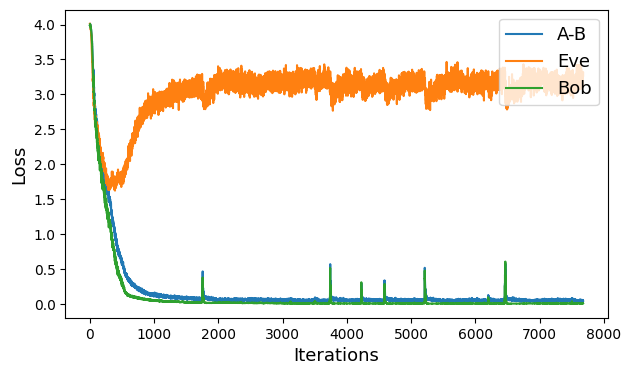

In [17]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B', alpha=0.99)
plt.plot(evelosses[:steps], label='Eve', alpha=0.99)
plt.plot(boblosses[:steps], label='Bob', alpha=0.99)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13, loc='upper right')

plt.savefig("images/" + model_name + "-all.png", transparent=True) #dpi=100
plt.show()

In [18]:
alice.save(alice_file + '.h5', overwrite=True)
bob.save(bob_file + '.h5', overwrite=True)
eve.save(eve_file + '.h5', overwrite=True)

C:\Users\aatis\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
alice = load_model(alice_file + '.h5')
bob = load_model(bob_file + '.h5')
eve = load_model(eve_file + '.h5')

### Evaluate

In [20]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])

m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

313/313 [==============================] - 2s 5ms/step
Bob % correct:  99.87 %
Eve % correct:  1.95 %


In [21]:
alice = load_model('models/crypto/ANC-alice.h5')
bob = load_model('models/crypto/ANC-bob.h5')
eve = load_model('models/crypto/ANC-eve.h5')

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_entropy(sequence, name):
    _, counts = np.unique(sequence, return_counts=True)
    probabilities = counts / len(sequence)
    entropy = -np.sum(probabilities * np.log2(probabilities))

    # Plotting
    plt.bar([0, 1], probabilities, tick_label=[0, 1])
    plt.title(f"Entropy of {name}: {entropy:.2f}")
    plt.xlabel("Binary Value")
    plt.ylabel("Probability")
    plt.show()

# Example usage:
# Assuming `m_batch`, `m_dec`, and `m_att` are binary sequences
plot_entropy(m_batch.flatten(), "m_batch")
plot_entropy(m_dec.flatten(), "m_dec")
plot_entropy(m_att.flatten(), "m_att")


NameError: name 'm_batch' is not defined

## Char map and str functions

In [6]:
block_size_unpadded = 5
block_padding = 3
block_size = block_size_unpadded + block_padding
#Dictonary and corresponding binary
#the standard parameters: message, key, and ciphertext bit lengths
m_bits = 8
k_bits = 8
c_bits = 8
pad = 'same'

chrlist = [
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
    'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '!', '?',
    ':', ' '
]
binlist = [
    '00000', '00001', '00010', '00011', '00100', 
    '00101', '00110', '00111', '01000', '01001',
    '01010', '01011', '01100', '01101', '01110', 
    '01111', '10000', '10001', '10010', '10011',
    '10100', '10101', '10110', '10111', '11000',
    '11001', '11010', '11011', '11100', '11101', 
    '11110', '11111'
]

def randombits(n):
    if n == 0:
        return ''
    decvalue = np.random.randint(0, 2**n)
    formatstring = '0' + str(n) + 'b'
    return format(decvalue, formatstring)

def encstr(message, block_padding=0):
    cipher = ""
    for c in message:
        binstr = binlist[chrlist.index(c)]
        binstrpadded = randombits(block_padding) + str(binstr)
        cipher = cipher + binstrpadded
    return cipher, len(message)

def decstr(cipher, n, block_padding=0):
    message = ""
    cipherlength = len(cipher)
    block_size = cipherlength // n
    for i in range(n):
        blockpadded = cipher[block_size*i : block_size*i + block_size]
        blockunpadded = blockpadded[block_padding:]
        character = chrlist[binlist.index(blockunpadded)]
        message = message + character
    return message

In [23]:
print(encstr('adi', 3))
print(decstr('00010011010001001001001001010011', 4, block_padding=3))

('100000001010001100101000', 3)
test


In [24]:
# Function for converting float to 32-bit binary string
def float_to_binary(value):
    binNum = bin(  ctypes.c_uint.from_buffer(ctypes.c_float(value)).value  )[2:]
    binstr = binNum.rjust(32,"0")
    return binstr

def binary_to_float(binstr):
    intvalue = int(binstr, 2)
    floatvalue = ctypes.c_float.from_buffer(ctypes.c_uint(intvalue))
    return floatvalue.value

# Convert a positive integer num into a bit vector of 'bits' size
def bitarray(num, bits):
    return np.array(list(np.binary_repr(num).zfill(bits))).astype(np.int8)

In [29]:
key = np.array([[0,0,0,0,0,0,0,0]])
m = 'aatish'

m_bin, _ = encstr(m, block_padding=3)
m_bin_len = len(m_bin)
print(m_bin, m_bin_len)

ciphertext = ""
for i in range(m_bin_len // m_bits):
    # read blocks of size m_bits
    binblockstr = m_bin[m_bits*i : m_bits*i + m_bits]
    binblock = np.array(list(binblockstr)).astype(np.int8).reshape(1, m_bits)
    
    floatVector = alice.predict([binblock, key])

    for j in range(c_bits):
        ciphertext = ciphertext + float_to_binary(floatVector[0][j])
        #print(float_to_binary(floatVector[0][j]))

print(ciphertext, len(ciphertext)) # ciphertext in binary
print(decstr(ciphertext, n=(len(ciphertext)//8), block_padding=3)) #ciphertext as characters

ciphertext_len = len(ciphertext)
plaintextbin = ""
for i in range(ciphertext_len // (c_bits*32)):
    # read the ciphertext in chunks of 32*c_bits bits, i.e one encoding at a time
    floatVectorbin = ciphertext[c_bits*32*i : c_bits*32*i + c_bits*32]
    #print(floatVectorbin)
    # convert the binary chunk to an 8-dim float vector (input for AI Bob)
    floatVector = np.zeros(c_bits, dtype=np.float32).reshape(1, c_bits)
    for j in range(len(floatVectorbin) // 32):
        floatValuebin = floatVectorbin[32*j : 32*j + 32]
        #print(floatValuebin)
        floatValue = binary_to_float(floatValuebin)
        floatVector[0][j] = floatValue
    #print(np.round(floatVector,3))
    
    charbinvector = list( (bob.predict([floatVector, key]) > 0.5)[0].astype(int) )
    for j in range(len(charbinvector)):
        plaintextbin = plaintextbin + str(charbinvector[j])

print(plaintextbin)

m_dec = ""
for i in range(len(plaintextbin) // m_bits):
    strbin = plaintextbin[m_bits*i : m_bits*i + m_bits]
    m_dec = m_dec + decstr(strbin, len(strbin)//m_bits, block_padding=3)

print(m_dec)

001000000000000001010011001010001001001000000111 48
1/1 [==============================] - 0s 58ms/step
:dlk?fqs?uv.?mok?wsw?blv:l l?.ii:t.y?zuk?lzm?eim?v?o?t:i:hyy??gi:vwr?!yt?dkc?dmj?ya.?j!z:mpt!v.o?,fy?gkl?zzv!ejb?ig:?b,.: q.?kqg:nuq?jlv?fad?,nw?ok ?lxs?tnd,g.y:jvt?cb!?,!x?vmf? gq?kik:kxm?tba
1/1 [==============================] - 0s 60ms/step
001000000000000001010011001010001001001000000111
aatish


In [30]:
# Eves output for the given input
plaintextbin = ""
for i in range(ciphertext_len // (c_bits*32)):
    floatVectorbin = ciphertext[c_bits*32*i : c_bits*32*i + c_bits*32]
    floatVector = np.zeros(c_bits, dtype=np.float32).reshape(1, c_bits)
    for j in range(len(floatVectorbin) // 32):
        floatValuebin = floatVectorbin[32*j : 32*j + 32]
        floatValue = binary_to_float(floatValuebin)
        floatVector[0][j] = floatValue
    charbinvector = (eve.predict(floatVector) > 0.5).astype(int)
    for j in range(charbinvector.shape[1]):
        plaintextbin = plaintextbin + str(charbinvector[0][j])

print(plaintextbin)

m_dec = ""
for i in range(len(plaintextbin) // m_bits):
    strbin = plaintextbin[m_bits*i : m_bits*i + m_bits]
    m_dec = m_dec + decstr(strbin, len(strbin)//m_bits, block_padding=3)

print(m_dec)

1/1 [==============================] - 0s 71ms/step
111100111101011111110001111001111101011111010111
txrhxx


In [12]:

import numpy as np
import ctypes
#the standard parameters: message, key, and ciphertext bit lengths
model_name = 'ANC'
# 
# 
# import tensorflow as tf
# import ctypes
# import gmpy2
# from gmpy2 import mpz
# import matplotlib
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import sys
# 
# from keras import backend as K
# from keras.models import Model
# from keras.layers import Input
# from keras.layers import Activation, Dense
# from keras.layers import Flatten, Reshape
# from keras.layers import Conv1D
# from keras.layers import concatenate
# from keras.optimizers import Adam, RMSprop
from keras.models import load_model
#the standard parameters: message, key, and ciphertext bit lengths
m_bits = 8
k_bits = 8
c_bits = 8
pad = 'same'
# Compute the size of the message space
m_train = 2**(m_bits + k_bits)

alice_file = 'models/crypto/' + model_name + '-alice'
bob_file = 'models/crypto/' + model_name + '-bob'
eve_file = 'models/crypto/' + model_name + '-eve'
alice = load_model(alice_file + '.h5')
bob = load_model(bob_file + '.h5')
eve = load_model(eve_file + '.h5')
block_size_unpadded = 5
block_padding = 3
block_size = block_size_unpadded + block_padding
#Dictonary and corresponding binary
chrlist = [
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
    'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '!', '?',
    ':', ' '
]
binlist = [
    '00000', '00001', '00010', '00011', '00100', 
    '00101', '00110', '00111', '01000', '01001',
    '01010', '01011', '01100', '01101', '01110', 
    '01111', '10000', '10001', '10010', '10011',
    '10100', '10101', '10110', '10111', '11000',
    '11001', '11010', '11011', '11100', '11101', 
    '11110', '11111'
]

def randombits(n):
    if n == 0:
        return ''
    decvalue = np.random.randint(0, 2**n)
    formatstring = '0' + str(n) + 'b'
    return format(decvalue, formatstring)

def encstr(message, block_padding=0):
    cipher = ""
    for c in message:
        binstr = binlist[chrlist.index(c)]
        binstrpadded = randombits(block_padding) + str(binstr)
        cipher = cipher + binstrpadded
    return cipher, len(message)

def decstr(cipher, n, block_padding=0):
    message = ""
    cipherlength = len(cipher)
    block_size = cipherlength // n
    for i in range(n):
        blockpadded = cipher[block_size*i : block_size*i + block_size]
        blockunpadded = blockpadded[block_padding:]
        character = chrlist[binlist.index(blockunpadded)]
        message = message + character
    return message

# Function for converting float to 32-bit binary string
def float_to_binary(value):
    binNum = bin(  ctypes.c_uint.from_buffer(ctypes.c_float(value)).value  )[2:]
    binstr = binNum.rjust(32,"0")
    return binstr

def binary_to_float(binstr):
    intvalue = int(binstr, 2)
    floatvalue = ctypes.c_float.from_buffer(ctypes.c_uint(intvalue))
    return floatvalue.value

# Convert a positive integer num into a bit vector of 'bits' size
def bitarray(num, bits):
    return np.array(list(np.binary_repr(num).zfill(bits))).astype(np.int8)

def encrypt_message(message, key):
    # Convert message to binary
    m_bin, _ = encstr(message, block_padding=3)
    m_bin_len = len(m_bin)
    
    ciphertext = ""
    for i in range(m_bin_len // m_bits):
        # Read blocks of size m_bits
        binblockstr = m_bin[m_bits * i: m_bits * i + m_bits]
        binblock = np.array(list(binblockstr)).astype(np.int8).reshape(1, m_bits)

        floatVector = alice.predict([binblock, key])

        for j in range(c_bits):
            ciphertext += float_to_binary(floatVector[0][j])

    return ciphertext

def decrypt_message(ciphertext, key):
    plaintextbin = ""
    ciphertext_len = len(ciphertext)
    
    for i in range(ciphertext_len // (c_bits * 32)):
        # Read the ciphertext in chunks of 32 * c_bits bits, i.e., one encoding at a time
        floatVectorbin = ciphertext[c_bits * 32 * i: c_bits * 32 * i + c_bits * 32]
        
        # Convert the binary chunk to an 8-dim float vector (input for AI Bob)
        floatVector = np.zeros(c_bits, dtype=np.float32).reshape(1, c_bits)
        for j in range(len(floatVectorbin) // 32):
            floatValuebin = floatVectorbin[32 * j: 32 * j + 32]
            floatValue = binary_to_float(floatValuebin)
            floatVector[0][j] = floatValue
        
        charbinvector = list((bob.predict([floatVector, key]) > 0.5)[0].astype(int))
        for j in range(len(charbinvector)):
            plaintextbin += str(charbinvector[j])

    m_dec = ""
    for i in range(len(plaintextbin) // m_bits):
        strbin = plaintextbin[m_bits * i: m_bits * i + m_bits]
        m_dec += decstr(strbin, len(strbin) // m_bits, block_padding=3)

    return m_dec

# Assuming you have a message and a key
message = "hello, world!"
key = np.array([[0, 1, 0, 1, 1, 0, 1, 0]])  # Example key, adjust as needed

# Encryption
ciphertext = encrypt_message(message, key)

# Decryption
decrypted_message = decrypt_message(ciphertext, key)

print("Original message:", message)
print("Encrypted ciphertext:", ciphertext)
print("Decrypted message:", decrypted_message)



1/1 [==============================] - 0s 56ms/step
Original message: hello, world!
Encrypted ciphertext: 101111010000100110101111001101011011110101011101110110100111011000111110000110011110000000111000001111100000111100011000111111111011111000010011111000100111100010111110000010000110110000011010001111010001101100010111101110101011111010110100001110101001001110111101001101101101010100111011101111010000110100101011110100100011111000010111000110011110001000111110000011000000000111111000101111100001010001010011010110101011111000000111010001110001101000111101100001001010001110010011101111101010010010111010011001011011110101010100111100011010011010111100111000000100101101011001001111011101101110110010110010100011111000000111001000110110000010111101111000001111001001100011101111100110001001000111000000110011110100110001001101010101000110111110101111100101101011100110101111010110011100110001011001001011110011100000111001101010001100111101110010111110110001100111001111011111010111011111010101

Ciphertext (Binary): 
Ciphertext (String): 


Ciphertext (Binary): 
Ciphertext (String): 
